# Dependencies

In [1]:
from datetime import datetime
import random
import numpy as np
import pandas as pd
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef, auc, accuracy_score, classification_report, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, add, GlobalAveragePooling2D, BatchNormalization, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data Cleaning

In [4]:
data.shape

(91820, 8)

In [5]:
data = data[(data["ETHNICITY_DESC"] == "African American  or Black") | (data["ETHNICITY_DESC"] == "Caucasian or White")]
tissden_5 = data[data["tissden"] == 5.0].index
data = data.drop(tissden_5, axis=0)

In [6]:
data.shape

(86312, 8)

In [7]:
patients = data.drop_duplicates(subset="empi_anon")

In [8]:
patients["ETHNICITY_DESC"].value_counts()

African American  or Black    13848
Caucasian or White            13183
Name: ETHNICITY_DESC, dtype: int64

In [9]:
data["ETHNICITY_DESC"].value_counts()

African American  or Black    43507
Caucasian or White            42805
Name: ETHNICITY_DESC, dtype: int64

In [10]:
data["GENDER_DESC"].value_counts()

Female    86084
Male        228
Name: GENDER_DESC, dtype: int64

In [ ]:
#Insert path to data csv here where image path is under the column png_path and the race label is under the column ETHNICITY_DESC
data_path = ""
data = pd.read_csv(data_path)

# Exploratory Data Analysis

(array([43507.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 42805.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

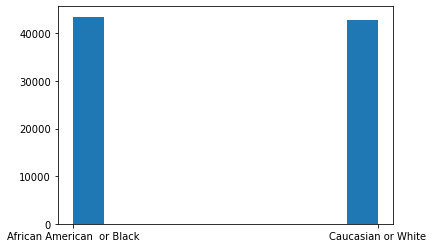

In [11]:
plt.hist(data["ETHNICITY_DESC"])

In [12]:
data.head()

,acc_anon,ETHNICITY_DESC,tissden,GENDER_DESC,age_at_study,png_path,empi_anon,StudyID
0,5398957042576578,African American or Black,1.0,Female,66.306632,/home/jupyter-zaiman/data/mammo/png_kheiron/co...,77670546,MG Screening Dig
6,2758514113950519,Caucasian or White,2.0,Female,79.719638,/home/jupyter-zaiman/data/mammo/png_kheiron/co...,90697978,MG Screening Dig
11,6928226311930500,Caucasian or White,2.0,Female,68.299828,/home/jupyter-zaiman/data/mammo/png_kheiron/co...,32811576,MG Screening Dig
16,1546724535446938,African American or Black,3.0,Female,69.301902,/home/jupyter-zaiman/data/mammo/png_kheiron/co...,74534019,MG Screening Dig
24,9192518631958436,Caucasian or White,2.0,Female,76.393081,/home/jupyter-zaiman/data/mammo/png_kheiron/co...,49367954,MG Screening Dig


# Batch Generation

In [13]:
HEIGHT, WIDTH = 256, 256
lr = 1e-3
BATCH_SIZE = 32
EPOCHS = 3
TEST_BATCH = 32

In [14]:
random.seed(42)
unique_empi = set()
for empi in data["empi_anon"]:
    unique_empi.add(empi)
train_empi = random.sample(list(unique_empi), int(len(unique_empi)*0.6))
valid_empi = []
for empi in unique_empi:
    if empi not in set(train_empi):
        valid_empi.append(empi)
test_empi = random.sample(valid_empi, int(len(valid_empi)*0.5))
valid_actual_empi = []
for empi in valid_empi:
    if empi not in set(test_empi):
        valid_actual_empi.append(empi)
train = data[data["empi_anon"].isin(train_empi)]
valid = data[data["empi_anon"].isin(valid_actual_empi)]
test = data[data["empi_anon"].isin(test_empi)]

In [15]:
train.to_csv("mammo_train.csv")
valid.to_csv("mammo_valid.csv")
test.to_csv("mammo_test.csv")

In [18]:
train_gen = ImageDataGenerator(
            rotation_range=15,
            fill_mode='constant',
            zoom_range=0.1,
            horizontal_flip=True,
            rescale = 1./255
)

validate_gen = ImageDataGenerator(rescale = 1./255)

In [19]:
train_batches = train_gen.flow_from_dataframe(train, 
                                              directory=None, 
                                              x_col="png_path", y_col="ETHNICITY_DESC", 
                                              class_mode="categorical",
                                              target_size=(HEIGHT, WIDTH),
                                              shuffle=True,
                                              seed=1,
                                              batch_size=BATCH_SIZE, 
                                              dtype='float32')

validate_batches = validate_gen.flow_from_dataframe(valid, 
                                                    directory=None, 
                                                    x_col="png_path", 
                                                    y_col="ETHNICITY_DESC", 
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH),
                                                    shuffle=False,
                                                    batch_size=TEST_BATCH, 
                                                    dtype='float32')
test_batches = validate_gen.flow_from_dataframe(test, 
                                                    directory=None, 
                                                    x_col="png_path", 
                                                    y_col="ETHNICITY_DESC", 
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH),
                                                    shuffle=False,
                                                    batch_size=TEST_BATCH, 
                                                    dtype='float32')

Found 51749 validated image filenames belonging to 2 classes.
Found 17362 validated image filenames belonging to 2 classes.
Found 17201 validated image filenames belonging to 2 classes.


# Training

In [ ]:
train_epoch = math.ceil(len(train) / BATCH_SIZE)
val_epoch = math.ceil(len(valid) / TEST_BATCH)

In [ ]:
input_a = Input(shape=(HEIGHT, WIDTH, 3))
base_model = efn.EfficientNetB2(input_tensor=input_a, include_top=False, input_shape=(HEIGHT,WIDTH,3), weights='noisy-student')
x = GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(2, name='dense_logits')(x)
output = layers.Activation('softmax', dtype='float32', name='predictions')(x)
model = Model(inputs=input_a, outputs=output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(lr),
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=[
                        tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
                        tf.keras.metrics.AUC(curve='PR', name='PR-AUC')])

In [ ]:
arc_name = "Emory_Mammo" + str(HEIGHT) + "x" + str(WIDTH) + "resnet50-race"

In [ ]:
var_date = datetime.now().strftime("%Y%m%d-%H%M%S")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1,
                              patience=2, min_lr=1e-6, verbose=1)
ES = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)
checkloss = ModelCheckpoint("mammo_efficientnetB2_binary.hdf5", monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [ ]:

with tf.device("/device:GPU:2"):
    history = model.fit(train_batches,
              validation_data=validate_batches,
              epochs=100,
              steps_per_epoch=int(train_epoch),
              validation_steps=int(val_epoch),
              shuffle=True,
              callbacks=[reduce_lr, checkloss, ES]
    )